# <center> Исследование данных HR-агентства

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Описание исходных данных:

- **work_year** - Год, в котором была выплачена зарплата.
- **experience_level** - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
- **employment_type** - Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
- **job_title** - Роль, в которой соискатель работал в течение года.
- **salary** - Общая выплаченная валовая сумма заработной платы.
- **salary_currency** - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- **salary_in_usd** - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через [fxdata.foorilla.com]).
- **employee_residence** - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- **remote_ratio** - Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
- **company_location** - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- **company_size** - Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

## Загрузка данных

In [12]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [13]:
df_ds_salaries = pd.read_csv('./data/ds_salaries.csv', index_col=0)
df_ds_salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [14]:
# уровень значимости
alpha = 0.05

## Описательный анализ данных

In [36]:
df_ds_salaries.info()
print(f'Количество пропущенных значений в исходных данных: {df_ds_salaries.isna().sum().sum()}')

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB
Количество пропущенных значений в исходных данных: 0


Исходные данные содержат 607 записей, пропущенных значений нет.

In [37]:
print(f'Количество дубликатов: {df_ds_salaries.duplicated().sum()}')

# Удаление дубликатов
df_ds_salaries_cleared = df_ds_salaries.drop_duplicates()
print(f'Размерность таблицы после удаления дубликатов: {df_ds_salaries_cleared.shape}')

Количество дубликатов: 42
Размерность таблицы после удаления дубликатов: (565, 11)


После очистки исходных данных от дубликатов количество строк в датасете сократилось до 565.

### Предварительная подготовка

Определение типов признаков:  
- **work_year** (Год выплаты зарплаты) - числовой дискретный;
- **experience_level** (Опыт работы на должности в течение года) - порядковый категориальный;
- **employment_type** (Тип трудоустройства) - номинальный категориальный;
- **job_title** - (Роль, в которой соискатель работал в течение года) - номинальный категориальный;
- ~~*salary*~~ (Общая выплаченная валовая сумма заработной платы) - подлежит удалению;
- ~~*salary_currency*~~ (Валюта выплачиваемой заработной платы) - подлежит удалению;
- **salary_in_usd** (Зарплата в долларах США) - числовой непрерывный;
- **employee_residence** (Основная страна проживания сотрудника) - номинальный категориальный;
- **remote_ratio** (Общий объём работы, выполняемой удалённо) - порядковый категориальный (представлен в числовом виде);
- **company_location** (Страна главного офиса работодателя или филиала по контракту) - номинальный категориальный;
- **company_size** (Среднее количество людей, работавших в компании в течение года) - порядковый категориальный.

Признаки ~~*salary*~~ и ~~*salary_currency*~~ подлежат удалению, так как в датасете присутствует признак **salary_in_usd**, который уже объединяет в себе данные из них в единой валюте (USD).

In [17]:
# Удаление неинформативных признаков
df_ds_salaries_cleared = df_ds_salaries_cleared.drop(columns=['salary', 'salary_currency'],
                                                     axis=1)
df_ds_salaries_cleared.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


### Основные статистические характеристики признаков

In [34]:
df_ds_salaries_cleared.describe().round(2)

,work_year,salary_in_usd,remote_ratio
count,565.00,565.00,565.00
mean,2021.36,110610.34,69.91
std,0.70,72280.70,40.90
min,2020.00,2859.00,0.00
25%,2021.00,60757.00,50.00
50%,2021.00,100000.00,100.00
75%,2022.00,150000.00,100.00
max,2022.00,600000.00,100.00


In [33]:
df_ds_salaries_cleared.describe(include='object')

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,565,565,565,565,565,565
unique,4,4,50,57,50,3
top,SE,FT,Data Scientist,US,US,M
freq,243,546,130,295,318,290


### Общее распределение заработной платы

In [18]:
# Инициализация полотна на два графика с общей осью X
fig_salary = make_subplots(rows=2, cols=1,
                           shared_xaxes=True, # Общая ось Х
                           x_title='Заработная плата, $',
                           y_title='Количество',
                           row_heights=[0.15, 0.85], # Относительная высота полотен
                           subplot_titles=("Общее распределение заработной платы", ""),
                           vertical_spacing=0.02) # Высота разделителя
# Построение коробчатой диаграммы
fig_salary.add_trace(go.Box(x=df_ds_salaries_cleared['salary_in_usd'],
                            marker_color = '#1729B0', # Цвет маркера
                            jitter=0.5, # Разнос точек выбросов по вертикали
                            name='',
                            showlegend=False),
                     row=1, col=1)
# Построение гистограммы
fig_salary.add_trace(go.Histogram(x=df_ds_salaries_cleared['salary_in_usd'],
                                  marker_color = '#1729B0', # Цвет маркера
                                  name='Заработная плата', # Название набора данных
                                  showlegend=False),
                     row=2, col=1)
# Построение линии среднего значения
fig_salary.add_vline(x=df_ds_salaries_cleared['salary_in_usd'].mean(),
                     line=dict(color="Red", dash='dash')) # Стиль линии)
# Размер полотна
fig_salary.update_layout(autosize = False, width = 1000, height = 620,
                         bargap=0.1) # Расстояние между столбцами гистограммы
fig_salary.show()

display(df_ds_salaries_cleared['salary_in_usd'].describe().round(2).to_frame())

,salary_in_usd
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Из формы гистограммы и неравенства среднего значения и медианы следует, что распределение заработной платы отлично от нормального, форма коробчатой диаграммы свидетельствует о наличии выбросов.

### Размер заработной платы у специалистов Data Scientist по годам

In [19]:
# Инициализация полотна
figure_salary_ds = make_subplots(rows=2, cols=1,
                                 subplot_titles=("Медиана заработной платы DS в 2020-2022 гг.", 
                                                 "Распределение заработной платы DS в 2020-2022 гг."),
                                 row_heights=[0.3, 0.7],
                                 vertical_spacing=0.15)
# Подготовка данных для отображения
mask_ds = df_ds_salaries_cleared['job_title'] == 'Data Scientist'
df_median_salaries_DS = df_ds_salaries_cleared[mask_ds].groupby(by=['work_year'])['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds.add_trace(go.Bar(x=df_median_salaries_DS.index.astype(str),
                                  y=df_median_salaries_DS,
                                  showlegend=False,
                                  marker_color = '#10c938'), # Цвет маркера
                            row=1, col=1)
# Построение коробчатой диаграммы
for year in df_median_salaries_DS.index:
    mask_year = df_ds_salaries_cleared['work_year'] == year
    figure_salary_ds.add_trace(go.Box(y=df_ds_salaries_cleared[mask_ds & mask_year]['salary_in_usd'],
                                      showlegend=False,
                                      name=year), # Название набора данных
                               row=2, col=1)
# Размер полотна
figure_salary_ds.update_layout(autosize = False, width = 1000, height = 720,
                               title='Размер заработной платы специалистов Data Scientist в 2020-2022 годах',
                               title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds.update_xaxes(title_text="Год", row = 2, col = 1)
figure_salary_ds.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds.show()

Здесь и для последующих расчетов из-за отсутствия признаков нормального распределения в данных о заработной плате в качестве меры центральной тенденции выбрана медиана значений.
Исходя из полученных графиков, у специалистов Data Scientist наблюдается ежегодный рост зарплат.

### Соотношение заработной платы Data Scientist и Data Engineer в 2022 году

In [20]:
# Инициализация полотна
figure_salary_ds_de = make_subplots(rows=2, cols=1,
                                    subplot_titles=("Медиана заработной платы DS и DE в 2022 г.", 
                                                    "Распределение заработной платы DS и DE в 2022 г."),
                                    row_heights=[0.3, 0.7],
                                    vertical_spacing=0.15)
# Подготовка данных для отображения
mask_2022 = df_ds_salaries_cleared['work_year'] == 2022
df_median_salaries_2022 = df_ds_salaries_cleared[mask_2022].groupby(by=['job_title'])['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds_de.add_trace(go.Bar(x=df_median_salaries_2022[['Data Scientist', 'Data Engineer']].index,
                                     y=df_median_salaries_2022[['Data Scientist', 'Data Engineer']],
                                     showlegend=False),
                              row=1, col=1)
# Построение коробчатой диаграммы
for title in ['Data Scientist', 'Data Engineer']:
    mask_title = df_ds_salaries_cleared['job_title'] == title
    figure_salary_ds_de.add_trace(go.Box(y=df_ds_salaries_cleared[mask_title & mask_2022]['salary_in_usd'],
                                         showlegend=False,
                                         name=title), # Название набора данных
                                  row=2, col=1)
# Размер полотна
figure_salary_ds_de.update_layout(autosize = False, width = 1000, height = 720,
                               title='Размер заработной платы специалистов Data Scientist в 2020-2022 годах',
                               title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds_de.update_xaxes(title_text="Специалист", row = 2, col = 1)
figure_salary_ds_de.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds_de.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds_de.show()

Исходя из полученных графиков, в 2022 году заработная плата специалистов Data Scientist выше, чем у специалистов Data Engineer.

### Соотношение заработной платы специалистов Data Scientist в компаниях различных размеров

In [21]:
# Инициализация полотна
figure_salary_ds_size_copm = make_subplots(rows=2, cols=1,
                                           subplot_titles=("Медиана заработной платы DS в компаниях различного размера", 
                                                         "Распределение заработной платы DS в компаниях различного размера"),
                                           row_heights=[0.3, 0.7],
                                           vertical_spacing=0.15)
# Подготовка данных для отображения
df_median_salaries_ds_size_copm = df_ds_salaries_cleared[mask_ds].groupby(by=['company_size'])['salary_in_usd'].median()
# Отрисовка баров
figure_salary_ds_size_copm.add_trace(go.Bar(x=df_median_salaries_ds_size_copm.index,
                                            y=df_median_salaries_ds_size_copm,
                                            showlegend=False),
                                     row=1, col=1)
# Построение коробчатой диаграммы
for size in df_median_salaries_ds_size_copm.index:
    mask_size = df_ds_salaries_cleared['company_size'] == size
    figure_salary_ds_size_copm.add_trace(go.Box(y=df_ds_salaries_cleared[mask_size & mask_ds]['salary_in_usd'],
                                                showlegend=False,
                                                name=size), # Название набора данных
                                         row=2, col=1)
# Размер полотна
figure_salary_ds_size_copm.update_layout(autosize = False, width = 1000, height = 720,
                               title='Размер заработной платы специалистов Data Scientist в компаниях различного размера',
                               title_x=0.5) # Выравнивание заголовка посередине 
# Подпись осей
figure_salary_ds_size_copm.update_xaxes(title_text="Размер компании", row = 2, col = 1)
figure_salary_ds_size_copm.update_yaxes(title_text="ЗП, $", row = 1, col = 1)
figure_salary_ds_size_copm.update_yaxes(title_text="Заработная плата, $", row = 2, col = 1)
figure_salary_ds_size_copm.show()

Распределение заработной платы специалистов Data Scientist в компаниях с разным штатом сотрудников различаются, при этом наиболее высокая зарплата ожидается в средних компаниях, такое различие по сравнению с крупными компаниями может объясняться наличием в крупных компаниях расширенных социальных гарантий и развитой дополнительной социальной инфраструктуры для своих сотрудников (спорт-залы, зоны отдыха и т.п.), а также, возможно, в крупных и средних компаниях масштабы решаемых задач соразмерны, но ввиду количества сотрудников, решающих их, итоговая нагрузка на каждого специалиста в отдельности в средних компаниях выше.

### Связь между наличием должностей Data Scientist и Data Engineer и размером компании

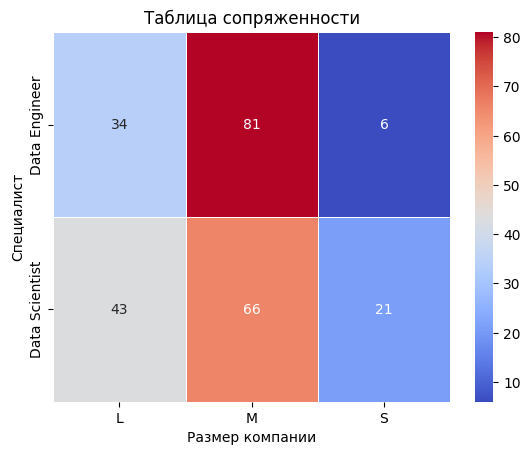

In [28]:
mask_de = df_ds_salaries_cleared['job_title'] == 'Data Engineer'
cross_tab = pd.crosstab(index=df_ds_salaries_cleared[mask_ds | mask_de]['job_title'], 
                        columns=df_ds_salaries_cleared[mask_ds | mask_de]['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Специалист')
plt.title('Таблица сопряженности')
plt.show()